## Imports 

In [1068]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, r2_score



# Double Machine Learning functions from EconML
import shap
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
from econml.grf import CausalForest


# Meta-Learners from EconML
from econml.metalearners import XLearner, TLearner, SLearner

## Preprocessing

Note almost all preprocessing steps have been done in other notebooks and have resulted in the csv imported below. See FLASH.ipynb and Flash_InterventionConsolide.ipynb for all steps. 

In [1069]:
socio_file = r"/socioEcodata.csv"
socio_csv_path = "/Users/finbarrhodes/Documents/Github/ST498_CAPSTONE/FLASH/toShare" + socio_file
df_socio = pd.read_csv(socio_csv_path)

In [1070]:
df_socio['ID'] = range(1,len(df_socio) + 1) # make IDs
id_dict = df_socio.set_index('HASH_KEY')['ID'].to_dict() # make dictionary with ID-hash key pairs

Importing data and Making clusters a categorical feature

In [1209]:
flash = pd.read_csv("/Users/finbarrhodes/Documents/GitHub/ST498_CAPSTONE/Notebooks/ANON_ID_w_socio_and_clusters.csv")

flash['ANON_ID'] = flash['ANON_ID'].map(id_dict)

# flash['Delta'] = flash['Delta'] * -1

# Changing cluster column type
flash['Cluster'] = flash['Cluster'].astype("int").astype("category")

flash['Group'] = np.where(flash['Group'] == 'Control', 0, 1)

# train-test split
flash_train, flash_test = train_test_split(flash, test_size=.2, random_state=1)


## DML Causal Forest Implementation

Encoding Categorical Variables

DML Components

We have to specify the following in our work: 

Outcome Variable Y:
- Peak-hour consumption change

Treatment Variable T:
- Binary of whether the ID was in intervention or control

**Heterogeneity Features X: 
- Cluster labels as dummy variables

**Control Features W:
- All other socioeconomic features


In [1103]:
features = ['AGE_GROUP', 'INCOME_CATEGORY', 'CHILDREN_AT_HOME'] 
            
"""'HOUSEHOLD_OCCUPANCY','HOUSEHOLD_SIZE','NUMBER_OF_BEDROOMS', 'OCCUPATION', 
'EMPLOYMENT_STATUS', 'HOME_OWNERSHIP', 'TARIFF_GROUP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE', 'HIGHEST_QUALIFICATION']
"""

cats = flash_train[features]


# Y -> Outcome Variable: Peak-hour consumption change
Y = np.ravel(flash_train[['Delta']])

# T -> Treatment Variable: Control vs. Intervention Group
T = flash_train[['Group']]

# X -> Heterogeneity Features: Cluster labels as dummies
# one-hot-encoding cluster membership 
"""
ohe = OneHotEncoder(sparse_output=False, drop=None)
encoded_clusters = ohe.fit_transform(flash_train[['Cluster']])
cluster_names = ohe.get_feature_names_out(['Cluster'])
"""

# making new df and replacing cluster column with encoded cluster columns in training set to use as X in cf
encoded_clusters = pd.get_dummies(flash_train[['Cluster']]).astype('int')
# pd.DataFrame(encoded_clusters, columns=category_names).astype('int')

# encoding socio features
encoded_socio = pd.get_dummies(flash_train[features]).astype("int")

X = pd.concat([encoded_clusters, encoded_socio], axis=1)

# W -> Control Features: All other socioeconomic variables (FOR NOW)
W = pd.get_dummies(cats)
# flash_train[features]


In [1073]:
# Problem: Too many features for our sample size

# Potential solutions:


# 1) Target Encoding
"""te = TargetEncoder()
te_encoded = pd.DataFrame(te.fit_transform(W,Y), columns=features)
"""
# 2) Lasso feature selection
"""
selector = SelectFromModel(Lasso(alpha=0.01))
W_dummies = pd.get_dummies(W, drop_first=True)
W_selected = selector.fit_transform(W_dummies, Y)
"""

# 3) Grouping levels within categories 
## i.e making income into low-med-high, children into yes/no, etc. 

# 4) Dimension reduction via PCA (seems like a stretch, loses interpretability)

# 5) Using domain knowledge to pick 'more important' ones to implement first, and adding ones until the model suffers 

'\nselector = SelectFromModel(Lasso(alpha=0.01))\nW_dummies = pd.get_dummies(W, drop_first=True)\nW_selected = selector.fit_transform(W_dummies, Y)\n'

First Stage Models

In [1074]:
# model Y -> uses features to predict the outcome Y 
model_y = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)

# model T -> uses featrues to predict the treatment T
model_t = RandomForestClassifier(n_estimators=500, min_samples_leaf=25)
# LogisticRegression()


In [1075]:
model_t.fit(X=X, y=T)

encoded_clusters_test = pd.get_dummies(flash_test[['Cluster']]).astype('int').astype('category')
encoded_socio_test = pd.get_dummies(flash_test[features]).astype("int").astype('category')
X_test = pd.concat([encoded_clusters_test, encoded_socio_test], axis=1)

model_t.predict(X_test)
scores = cross_val_score(model_t, X_test, flash_test['Group'], cv=5, scoring='roc_auc')
print(f"CV AUC score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CV AUC score: 0.5123 ± 0.1024


In [1076]:
model_y.fit(X=X, y=Y)
model_y.predict(X_test)
scores = cross_val_score(model_y, X_test, flash_test['Delta'], cv=5, scoring='r2')
print(f"R2: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

R2: -0.0549 ± 0.1466


Initializing Causal Forest

In [1077]:
cf = CausalForestDML(
    model_y=model_y,           # see above
    model_t=model_t,           # see above 
    n_estimators=100,          # Number of trees in the forest
    max_depth=None,              # Max depth of each tree
    min_samples_leaf=10,        # Min samples required in a leaf
    max_samples=0.45,           # Fraction of samples to use for each tree
    discrete_treatment=True,   # Binary treatment
    cv=5,                      # 5-fold cross-fitting
    honest=True,               # 'honest' splitting separates data used for node splitting and treatment effect measurement
    criterion='het',           # splitting criterion maximises heterogeneity score; could also use 'mse'
    random_state=1
)

# Fit the model
fit = cf.fit(Y, T, X=X, W=None, inference='blb')

In [1078]:
#X_test = ohe.fit_transform(flash_test[['Cluster']])

treatment_effects = cf.effect(X_test, T0=0, T1=1)
# this returns treatment for each row (individual) in the test set

# Get confidence intervals
lower, upper = cf.effect_interval(X_test, T0=0, T1=1, alpha=0.2)


In [1079]:
cf.effect_inference(X_test, T0=0, T1=1)

In [1080]:
"""
plt.hist(treatment_effects, bins=50)
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Heterogeneous Treatment Effects')
"""

"\nplt.hist(treatment_effects, bins=50)\nplt.xlabel('Estimated Treatment Effect')\nplt.ylabel('Frequency')\nplt.title('Distribution of Heterogeneous Treatment Effects')\n"

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Text(0, 0.5, 'Mean Treatment Effect')

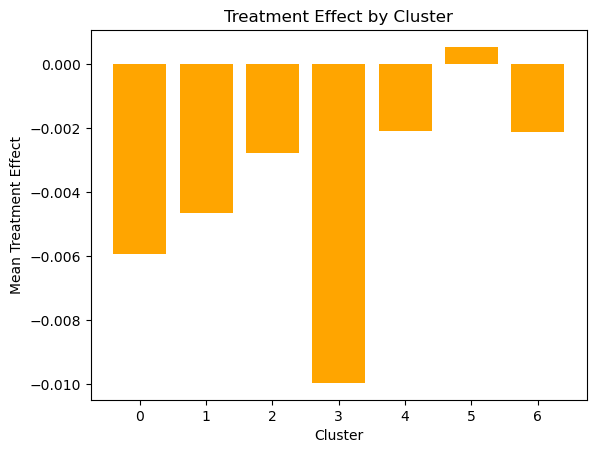

In [1081]:
results = pd.DataFrame({"ANON_ID" : flash_test['ANON_ID'],
                        "Cluster" : flash_test['Cluster'],
                        "Treatment Effect" : treatment_effects})

group_means = results.groupby('Cluster')['Treatment Effect'].mean()

plt.bar(results['Cluster'].unique(), group_means, capsize=10, color='orange', alpha=1)
# plt.hlines(y=0, xmax=8, xmin=0)
plt.title('Treatment Effect by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Treatment Effect')

'\nshap_values = cf.shap_values(X)\n# local view: explain heterogeneity for a given observation\nind=0\nshap.plots.force(shap_values["Y0"]["T0"][ind], matplotlib=True)\n# global view: explain heterogeneity for a sample of dataset\nshap.summary_plot(shap_values[\'Y0\'][\'T0\'])\n'

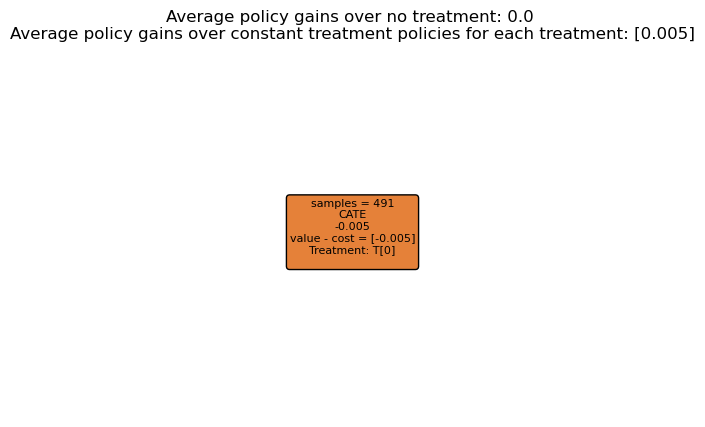

In [1082]:
# intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp = SingleTreePolicyInterpreter(risk_level=None, max_depth=2, min_samples_leaf=1,min_impurity_decrease=.001)

# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(cf, X)
# Plot the tree
intrp.plot(feature_names=[0,1,2,3,4,5,6], fontsize=8)

"""
shap_values = cf.shap_values(X)
# local view: explain heterogeneity for a given observation
ind=0
shap.plots.force(shap_values["Y0"]["T0"][ind], matplotlib=True)
# global view: explain heterogeneity for a sample of dataset
shap.summary_plot(shap_values['Y0']['T0'])
"""

Things that still need to be ironed out:

- Which socio features are in X
- How are the socio features encoded
- CF parameters

In [1083]:
pd.crosstab(flash['Cluster'], flash['Group'])

Group,0,1
Cluster,,
0,5,7
1,24,31
2,20,28
3,42,46
4,39,38
5,37,60
6,110,127


Tuning First Stage Models

In [1084]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_leaf': [5, 6, 7, 8, 9, 10, 12, 15, 20]}

# For the outcome model
grid_search_y = GridSearchCV(
    RandomForestRegressor(n_estimators=100),
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search_y.fit(np.hstack([X, W]), Y)
best_min_samples_leaf_y = grid_search_y.best_params_['min_samples_leaf']

# For the treatment model (if binary treatment)
grid_search_t = GridSearchCV(
    RandomForestClassifier(n_estimators=100),
    param_grid, 
    cv=5,
    scoring='roc_auc'
)
grid_search_t.fit(np.hstack([X, W]), T)
best_min_samples_leaf_t = grid_search_t.best_params_['min_samples_leaf']

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

In [1085]:
# Using cross-validation to evaluate first-stage models
from sklearn.model_selection import cross_val_score

# Check outcome model performance
y_scores = cross_val_score(model_y, np.hstack([X, W]), Y, cv=5, scoring='r2')
print(f"Outcome model R² (cross-val): {y_scores.mean():.3f} ± {y_scores.std():.3f}")

# Check treatment model performance (if binary)
t_scores = cross_val_score(model_t, np.hstack([X, W]), T, cv=5, scoring='roc_auc')
print(f"Treatment model AUC (cross-val): {t_scores.mean():.3f} ± {t_scores.std():.3f}")

Outcome model R² (cross-val): -0.138 ± 0.119


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Treatment model AUC (cross-val): 0.505 ± 0.011


## GRF Causal Forest

In [1221]:
features = ['AGE_GROUP', 'INCOME_CATEGORY', 'CHILDREN_AT_HOME'] 
            
"""'HOUSEHOLD_OCCUPANCY','HOUSEHOLD_SIZE','NUMBER_OF_BEDROOMS', 'OCCUPATION', 
'EMPLOYMENT_STATUS', 'HOME_OWNERSHIP', 'TARIFF_GROUP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE', 'HIGHEST_QUALIFICATION']
"""

# Y -> Outcome Variable: Peak-hour consumption change
Y = np.ravel(flash[['Delta']])

# T -> Treatment Variable: Control vs. Intervention Group
T = flash[['Group']]

# X -> Heterogeneity Features: Cluster labels as dummies
encoded_clusters = pd.get_dummies(flash[['Cluster']]).astype('int')
# pd.DataFrame(encoded_clusters, columns=category_names).astype('int')

# encoding socio features
encoded_socio = pd.get_dummies(flash[features]).astype("int")

X = pd.concat([encoded_clusters, encoded_socio], axis=1)

cf = CausalForest(
    n_estimators=5000,
    min_samples_leaf=5,
    #max_features='sqrt',
    criterion='het',
    honest=True,
    inference=True,
    random_state=1
)

# X would be your socioeconomic variables
cf.fit(X=X, T=T, y=Y)

# For each cluster, get the average estimated effect
for cluster_id in flash['Cluster'].unique():
    cluster_mask = (flash['Cluster'] == cluster_id)
    cluster_X = X[cluster_mask]
    
    cluster_effects = cf.predict(cluster_X)
    print(f"Cluster {cluster_id} average effect: {np.mean(cluster_effects)}")

# For each cluster, get the average estimated effect
for income_level in flash['INCOME_CATEGORY'].unique():
    group_mask = (flash['INCOME_CATEGORY'] == income_level)
    group_X = X[group_mask]
    
    group_effects = cf.predict(group_X)
    print(f"Income Category: {income_level} average effect: {np.mean(group_effects)}")

for age in flash['AGE_GROUP'].unique():
    group_mask = (flash['AGE_GROUP'] == age)
    group_X = X[group_mask]
    
    group_effects = cf.predict(group_X)
    print(f"Age Bracket: {age} average effect: {np.mean(group_effects)}")



Cluster 5 average effect: -0.011308350333179158
Cluster 6 average effect: -0.003387604326976697
Cluster 4 average effect: -0.0018011162680424283
Cluster 3 average effect: 0.003787451622150512
Cluster 2 average effect: 0.004446121199223412
Cluster 0 average effect: -0.001045715678563848
Cluster 1 average effect: -0.003152064472972665
Income Category: 100,000+ average effect: 0.002393940699227024
Income Category: 20,000-29,999 average effect: -0.002361269768043898
Income Category: 10,000-19,999 average effect: -0.00933221001098317
Income Category: 50,000-74,999 average effect: -0.0007814574263725993
Income Category: 30,000-39,999 average effect: -0.00560629919849555
Income Category: 40,000-49,999 average effect: -0.004598040695213209
Income Category: 75,000-99,999 average effect: -0.003821120585563977
Income Category: 0-9,999 average effect: -0.004183860252148279
Age Bracket: 55-64 average effect: -0.003118194860660307
Age Bracket: 65-74 average effect: -0.003062149751097961
Age Bracket:

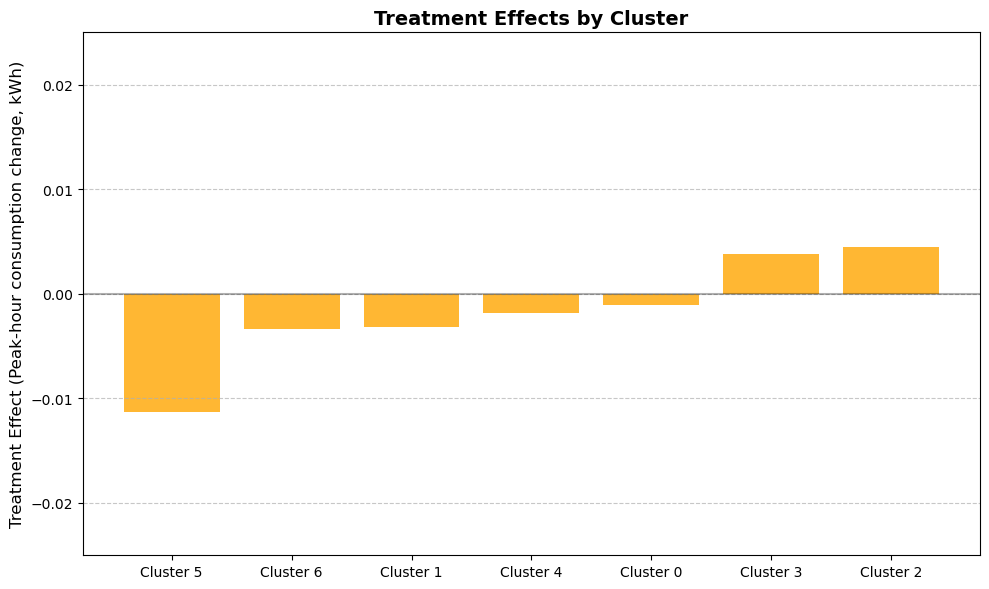

In [1222]:
# Calculate effects and confidence intervals for each cluster
results = []
for cluster_id in flash['Cluster'].unique():
    cluster_mask = (flash['Cluster'] == cluster_id)
    cluster_X = X[cluster_mask]
    
    # Get point estimates
    cluster_effects = cf.predict(cluster_X)
    mean_effect = np.mean(cluster_effects)
    
    # Get confidence intervals
    lower, upper = cf.predict_interval(cluster_X, alpha=.2)
    mean_lower = np.mean(lower)
    mean_upper = np.mean(upper)
    
    results.append({
        "cluster": f"Cluster {cluster_id}",
        "effect": mean_effect,
        "lower": mean_lower,
        "upper": mean_upper
    })

# Convert to DataFrame and sort by effect size
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="effect")

# Set up the plot
plt.figure(figsize=(10, 6))


# Create the barplot
bars = plt.bar(
    x=results_df["cluster"],
    height=results_df["effect"],
    color="orange",
    alpha=0.8
)

"""# Add error bars
plt.errorbar(
    x=range(len(results_df)),
    y=results_df["effect"],
    yerr=[
        results_df["effect"] - results_df["lower"],  # lower error
        results_df["upper"] - results_df["effect"]   # upper error
    ],
    fmt="none",
    ecolor="black",
    capsize=5
)"""

# Add a reference line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add titles and labels
plt.title("Treatment Effects by Cluster", fontsize=14, fontweight="bold")
plt.ylabel("Treatment Effect (Peak-hour consumption change, kWh)", fontsize=12)

# Customize y-axis to ensure it includes zero
buffer = 0.005 * (max(results_df["upper"]) - min(results_df["lower"]))
plt.ylim((-.025, .025))

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

"""# Add a note about confidence intervals
plt.figtext(
    0.5, 0.01,
    "Note: Error bars represent 80% confidence intervals",
    ha="center",
    fontsize=10,
    fontstyle="italic"
)"""

plt.tight_layout()

# Save the figure if needed
# plt.savefig("treatment_effects_by_cluster.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

In [1223]:

# Get feature importances
importances = cf.feature_importances_

# Match with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort and visualize
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
2,Cluster_2,0.144304
16,"INCOME_CATEGORY_100,000+",0.084741
5,Cluster_5,0.078547
20,"INCOME_CATEGORY_50,000-74,999",0.068678
11,AGE_GROUP_55-64,0.067404
24,CHILDREN_AT_HOME_2+,0.059282
6,Cluster_6,0.058035
22,CHILDREN_AT_HOME_0,0.054504
21,"INCOME_CATEGORY_75,000-99,999",0.043120
12,AGE_GROUP_65-74,0.041775


In [1089]:
# Calculate cluster-specific treatment effects
unique_clusters = np.unique(encoded_clusters.columns)
effects_by_cluster = {}

for cluster_id in unique_clusters:
    mask = (encoded_clusters.columns == cluster_id).ravel()
    if np.sum(mask) > 0:
        cluster_effects = treatment_effects[mask]
        effects_by_cluster[cluster_id] = {
            'mean': np.mean(cluster_effects),
            'count': np.sum(mask),
            'std': np.std(cluster_effects)
        }

print("\nTreatment Effects by Cluster:")
for cluster, stats in effects_by_cluster.items():
    print(f"Cluster {cluster}: ATE = {stats['mean']:.4f} (n = {stats['count']}, std = {stats['std']:.4f})")

# Get confidence intervals
try:
    variances = grf_cf.predict_var(X)
    std_errors = np.sqrt(variances)
    
    alpha = 0.05  # 95% confidence level
    z_score = 1.96  # Approximate z-score for 95% confidence
    
    lower_ci = treatment_effects - z_score * std_errors
    upper_ci = treatment_effects + z_score * std_errors
    
    cluster_cis = {}
    for cluster_id in unique_clusters:
        mask = (encoded_clusters.columns == cluster_id).ravel()
        if np.sum(mask) > 0:
            cluster_lower = lower_ci[mask]
            cluster_upper = upper_ci[mask]
            cluster_cis[cluster_id] = {
                'mean_lb': np.mean(cluster_lower),
                'mean_ub': np.mean(cluster_upper)
            }
    
    print("\nConfidence Intervals by Cluster (95%):")
    for cluster, ci in cluster_cis.items():
        print(f"Cluster {cluster}: [{ci['mean_lb']:.4f}, {ci['mean_ub']:.4f}]")
except Exception as e:
    print(f"\nUnable to calculate confidence intervals: {e}")

# Feature importance
if hasattr(grf_cf, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': grf_cf.feature_importances_
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print("\nTop features for treatment effect heterogeneity:")
    print(importance_df.head(10))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 123 but corresponding boolean dimension is 7

In [1219]:
flash['CHILDREN_AT_HOME'][flash['Cluster'] == 5].value_counts()

CHILDREN_AT_HOME
0     57
2+    23
1     17
Name: count, dtype: int64

In [1220]:
flash['CHILDREN_AT_HOME'].value_counts()

CHILDREN_AT_HOME
0     366
2+    130
1     118
Name: count, dtype: int64

In [1224]:
ordered_incomes = ['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', '40,000-49,999','50,000-74,999', '75,000-99,999', '100,000+' ]
eda_flash = pd.crosstab(flash['INCOME_CATEGORY'], flash['Cluster'])
eda_flash = eda_flash.reindex(ordered_incomes)


In [1225]:
# ordered_ages = ['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', '40,000-49,999','50,000-74,999', '75,000-99,999', '100,000+' ]
eda_flash = pd.crosstab(flash['INCOME_CATEGORY'], flash['Cluster'])
eda_flash = eda_flash.reindex(ordered_incomes)
eda_flash


Cluster,0,1,2,3,4,5,6
INCOME_CATEGORY,,,,,,,
"0-9,999",1,1,1,0,2,0,3
"10,000-19,999",0,3,2,2,1,7,16
"20,000-29,999",1,6,5,18,10,14,57
"30,000-39,999",0,9,7,10,10,10,26
"40,000-49,999",1,7,2,15,7,12,31
"50,000-74,999",6,14,11,31,22,31,68
"75,000-99,999",1,10,15,8,16,13,21
"100,000+",2,5,5,4,9,10,15


In [1226]:
flash['Group'].value_counts()

Group
1    337
0    277
Name: count, dtype: int64